<h1>Import Library</h1>

In [22]:
import re
import pandas as pd
import numpy as np
import nltk
import json
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import emoji
from nltk.tokenize import RegexpTokenizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.model_selection import train_test_split

<h1>Baca Data</h1>

In [7]:
df = pd.read_csv("label_manual.csv")
label_col = "label"
total_data = len(df)
labeled = df[label_col].notna().sum()
unlabeled = df[label_col].isna().sum()
label_counts = df[label_col].value_counts()

print("===== Statistik Labeling =====")
print(f"Total data        : {total_data}")
print(f"Sudah dilabeli    : {labeled}")
print(f"Belum dilabeli    : {unlabeled}")
print("\n--- Total per label ---")
print(label_counts)
texts = df["full_text"].astype(str)

===== Statistik Labeling =====
Total data        : 1905
Sudah dilabeli    : 250
Belum dilabeli    : 1655

--- Total per label ---
label
negative    100
positive    100
neutral      50
Name: count, dtype: int64


In [8]:
texts = df["full_text"].astype(str)

In [9]:
# Keywords yang menandakan teks relevan dengan topik kilang minyak Pertamina
topic_keywords = [
    "pertamina", "kilang minyak", "refinery", "bbm", "pertalite", "pertamax", 
    "solar", "avtur", "lpg", "spbu", "harga bbm", "subsidi bbm",
    
    # Nama-nama Kilang
    "balongan", "cilacap", "dumai", "plaju", "balikpapan", "kasim", "tuban",
    
    # Event/Isu Terkait
    "kebakaran kilang", "maintenance kilang", "produksi minyak", "impor minyak",
    "pasokan bbm", "mogok kerja", "patra niaga"
]

# Keywords yang menandakan teks tidak relevan atau spam
irrelevant_keywords = [
    # Spam umum
    "download", "promo", "iklan", "klik link", "aplikasi", "follow", 
    "giveaway", "voucher", "diskon", "gratis", "registrasi", "daftar",
    
    # Spam spesifik Pertamina (misal: lowongan palsu)
    "lowongan kerja pertamina", "loker pertamina", "rekrutmen pertamina",
    "undian pertamina", "hadiah pertamina", "cek profil saya"
]

# Fungsi Anda sekarang akan bekerja dengan benar untuk topik Anda
def is_relevant(text):
    text_lower = text.lower()
    # Jika ada kata kunci irelevan, langsung buang
    if any(bad in text_lower for bad in irrelevant_keywords):
        return False
    # Jika tidak ada yang irelevan, cek apakah ada kata kunci topik
    return any(topic in text_lower for topic in topic_keywords)

# Penerapannya tetap sama
mask = df["full_text"].astype(str).apply(is_relevant)
df_filtered = df[mask].reset_index(drop=True)
print(f"Jumlah data setelah pembersihan topik: {len(df_filtered)} baris tersisa.")

Jumlah data setelah pembersihan topik: 1310 baris tersisa.


<h1>PraPemrosesan import Stemmer dari Sastrawi<h1>

In [10]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_nltk = set(stopwords.words('indonesian'))
stop_sastrawi = set(StopWordRemoverFactory().get_stop_words())
stop_words = stop_nltk.union(stop_sastrawi)


tokenizer = RegexpTokenizer(r'\w+')

<h1>Pembersihan data menggunakan case folding</h1>

In [11]:
def case_folding(text):
    text = text.lower()
    return text

In [13]:
singkatan_pertamina_map = {
    "gk": "tidak", "ga": "tidak", "gak": "tidak", "nggak": "tidak", "ngga": "tidak",
    "tdk": "tidak", "tak": "tidak", "ndak": "tidak", "enggak": "tidak",
    "yg": "yang", "dgn": "dengan", "dg": "dengan", "krn": "karena", "karna": "karena",
    "utk": "untuk", "tp": "tapi", "pdhl": "padahal", "sm": "sama", "sma": "sama",
    "sdh": "sudah", "udh": "sudah", "udah": "sudah", "dah": "sudah", "blm": "belum",
    "jd": "jadi", "jg": "juga", "jgn": "jangan", "gmn": "bagaimana", "gimana": "bagaimana",
    "klo": "kalau", "klu": "kalau", "kalo": "kalau", "kl": "kalau",
    "sy": "saya", "gw": "saya", "gue": "saya", "admin": "saya", 
    "bgt": "banget", "skrg": "sekarang", "skr": "sekarang", "td": "tadi", "kmrn": "kemarin",
    "trus": "terus", "trs": "terus", "dr": "dari", "drpd": "daripada",
    "bbrp": "beberapa", "brp": "berapa", "sbg": "sebagai",
    "gpp": "tidak apa apa", "gapapa": "tidak apa apa",
    "thx": "terima kasih", "tq": "terima kasih", "makasih": "terima kasih",
    "ok": "baik", "oke": "baik", "sip": "baik",
    "dll": "", "dst": "", "dsb": "", 
    "wkwk": "", "wkwkwk": "", "haha": "", "hehe": "", "hihi": "",
    "ptm": "pertamina", "ptmn": "pertamina", "pertamini": "pertamina", 
    "bumn": "badan usaha milik negara",
    "esdm": "energi dan sumber daya mineral",
    "bph": "badan pengatur hilir minyak dan gas bumi",
    "skk": "satuan kerja khusus pelaksana kegiatan usaha hulu minyak dan gas bumi",
    "pem": "pemerintah", "pemda": "pemerintah daerah", "pemprov": "pemerintah provinsi", "pemkot": "pemerintah kota",
    "dpr": "dewan perwakilan rakyat",
    "bbm": "bahan bakar minyak",
    "lpg": "elpiji", "elpiji": "elpiji",
    "plt": "pertalite", "prtmx": "pertamax",
    "avtur": "bahan bakar pesawat",
    "spbu": "stasiun pengisian bahan bakar umum",
    "ru": "refinery unit", "refinery unit": "refinery unit",
    "blgn": "balongan", "balongan": "balongan",
    "clcp": "cilacap", "cilacap": "cilacap",
    "bpn": "balikpapan", "balikpapan": "balikpapan",
    "dumai": "dumai",
    "plaju": "plaju",
    "kasim": "kasim",
    "tuban": "tuban",
    "kbkrn": "kebakaran", "kebakaran": "kebakaran",
    "ldkn": "ledakan", "ledakan": "ledakan",
    "bcr": "bocor", "bocoran": "kebocoran",
    "cemar": "pencemaran", "polusi": "polusi",
    "lngk": "langka", "kelangkaan": "kelangkaan",
    "antri": "antrean", "antrian": "antrean",
    "hrg": "harga", "hargo": "harga", 
    "subsidi": "subsidi",
    "nps": "nilai produk samping",
    "tkp": "tempat kejadian perkara",
    "naek": "naik", "turun": "turun", "trun": "turun",
    "aman": "aman", "slmt": "selamat",
    "mhl": "mahal", "murah": "murah",
    "krj": "kerja", "proyek": "proyek",
    "eval": "evaluasi",
}

<h1>Preprocessing regex, tokenisasi dan pemakaian stemmer</h1>

In [14]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', ' ', text)     
    text = re.sub(r'@\w+', ' ', text)                
    text = emoji.demojize(text)                      
    text = re.sub(r'\d+', ' ', text)                 
    text = re.sub(r'[^\w\s]', ' ', text)             
    text = re.sub(r'(.)\1{2,}', r'\1', text)         
    text = re.sub(r'\s+', ' ', text).strip()         

    tokens = tokenizer.tokenize(text)

    tokens = [singkatan_pertamina_map.get(w, w) for w in tokens if w not in singkatan_pertamina_map or singkatan_pertamina_map[w] != ""]

    tokens = [w for w in tokens if w not in stop_words]

    tokens = [stemmer.stem(w) for w in tokens]

    return " ".join(tokens)

df["preprocessing"] = texts.apply(clean_text)

In [15]:
df_new = pd.DataFrame({
    "full_text": texts,
    "case_folding": texts.apply(case_folding),
    "preprocessing": df["preprocessing"]
})

<h1>N-Gram<h1>

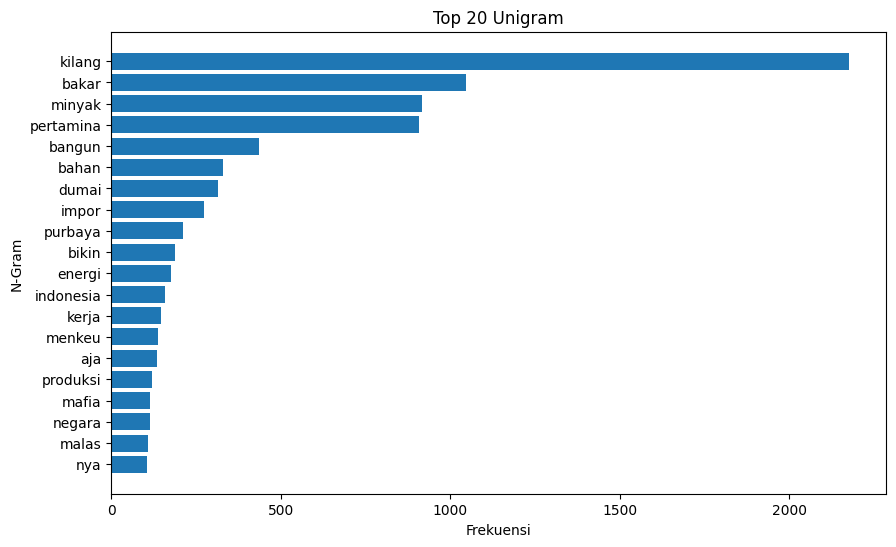

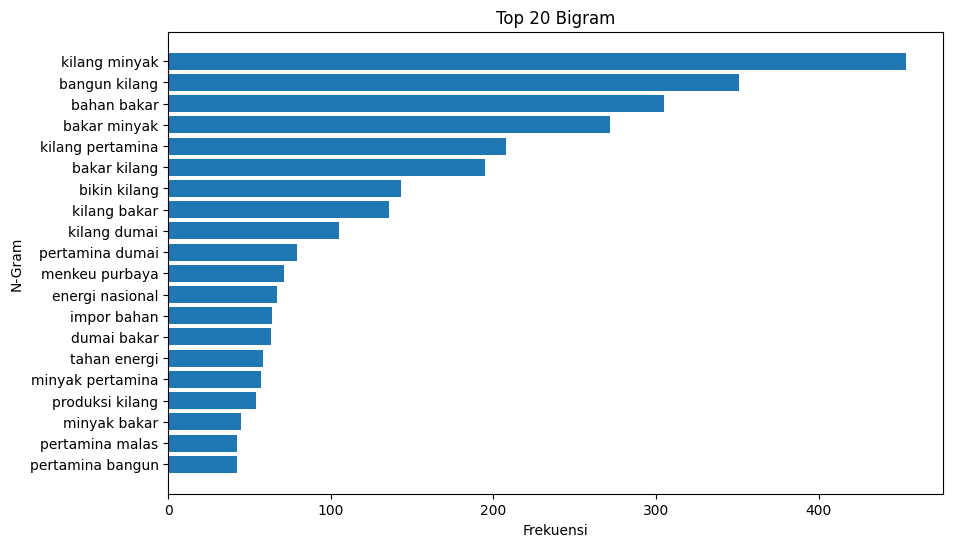

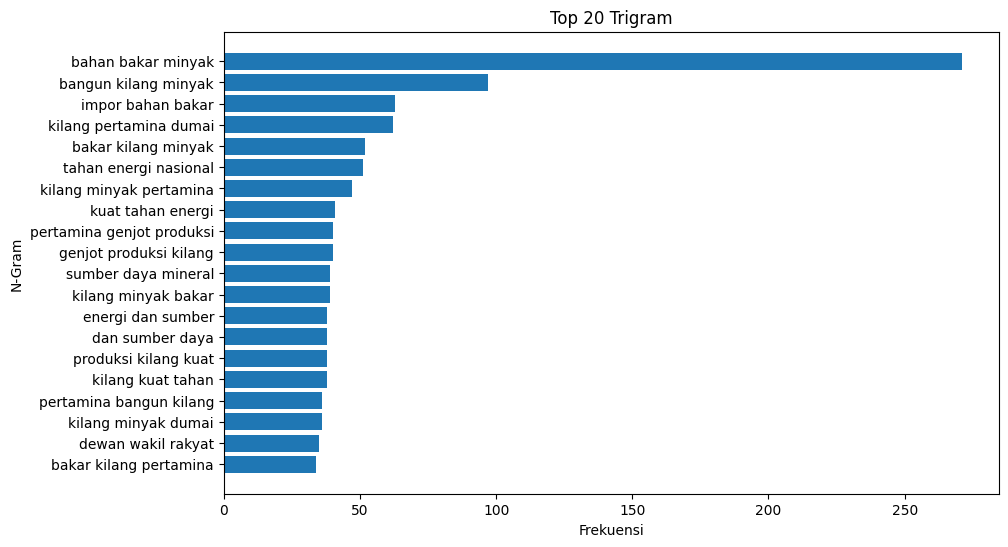

In [16]:
corpus = df_new["preprocessing"].astype(str)

def plot_top_ngrams(corpus, ngram_range=(2, 2), top_n=20, title="Top N-Grams"):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]

    ngram_df = pd.DataFrame(words_freq, columns=['NGram', 'Count'])

    plt.figure(figsize=(10,6))
    plt.barh(ngram_df['NGram'][::-1], ngram_df['Count'][::-1])
    plt.title(title)
    plt.xlabel("Frekuensi")
    plt.ylabel("N-Gram")
    plt.show()

plot_top_ngrams(corpus, ngram_range=(1, 1), title="Top 20 Unigram")
plot_top_ngrams(corpus, ngram_range=(2, 2), title="Top 20 Bigram")
plot_top_ngrams(corpus, ngram_range=(3, 3), title="Top 20 Trigram")

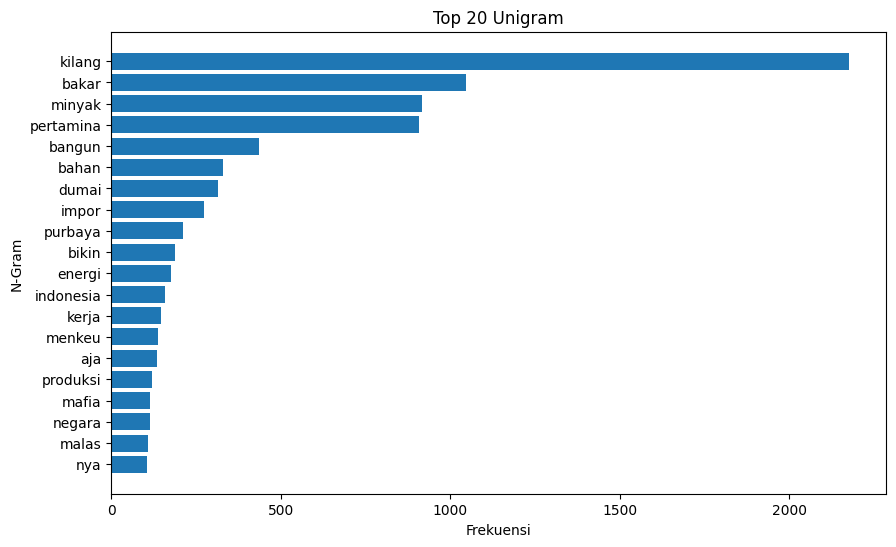

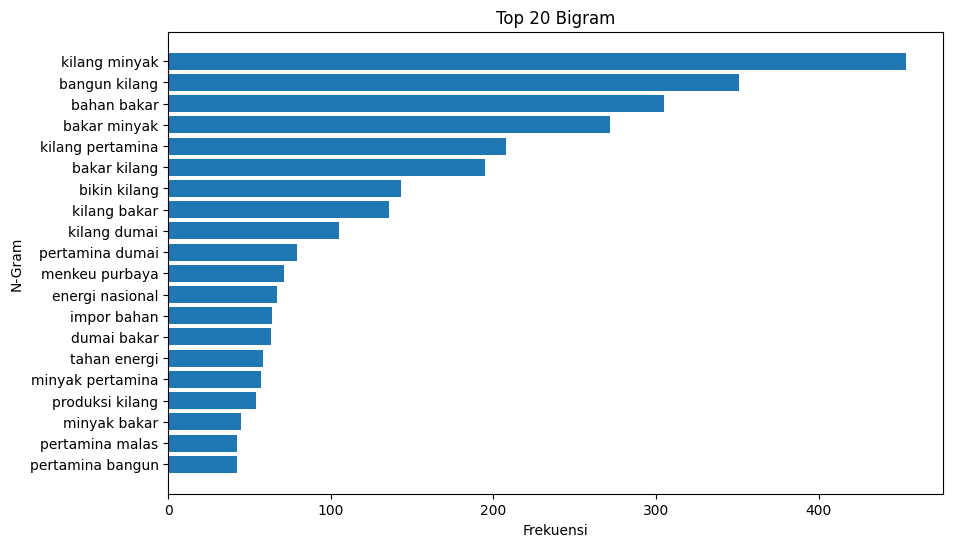

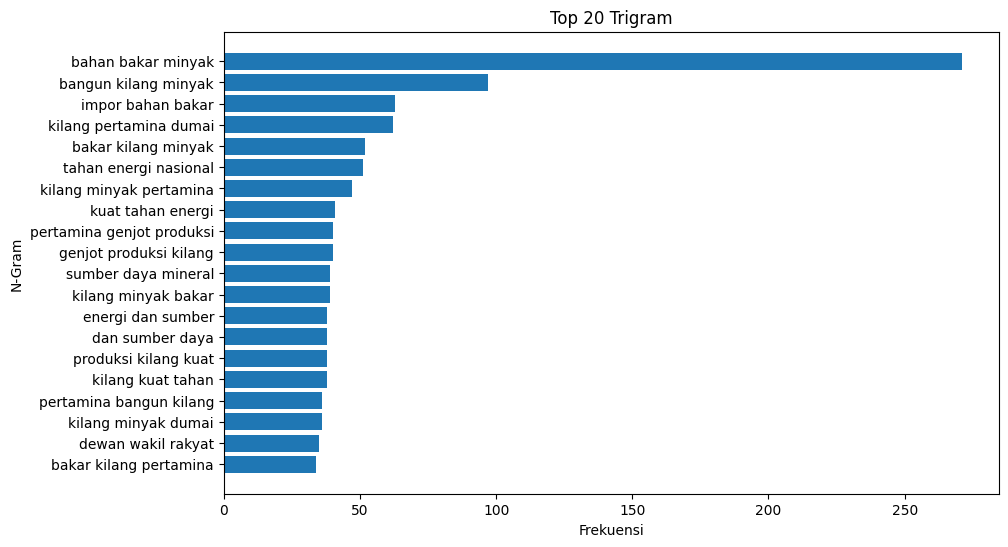

In [17]:
corpus = df_new["preprocessing"].astype(str)

def plot_top_ngrams(corpus, ngram_range=(2, 2), top_n=20, title="Top N-Grams"):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]

    ngram_df = pd.DataFrame(words_freq, columns=['NGram', 'Count'])

    plt.figure(figsize=(10,6))
    plt.barh(ngram_df['NGram'][::-1], ngram_df['Count'][::-1])
    plt.title(title)
    plt.xlabel("Frekuensi")
    plt.ylabel("N-Gram")
    plt.show()

plot_top_ngrams(corpus, ngram_range=(1, 1), title="Top 20 Unigram")
plot_top_ngrams(corpus, ngram_range=(2, 2), title="Top 20 Bigram")
plot_top_ngrams(corpus, ngram_range=(3, 3), title="Top 20 Trigram")

<h1>WordCloud<h1>

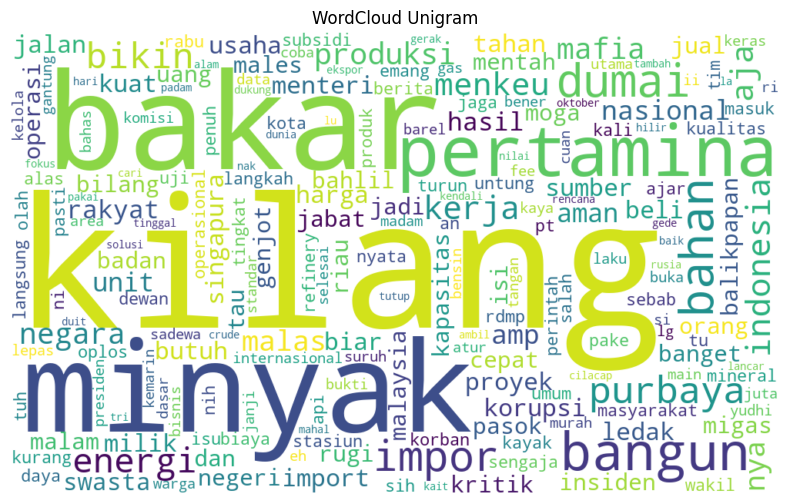

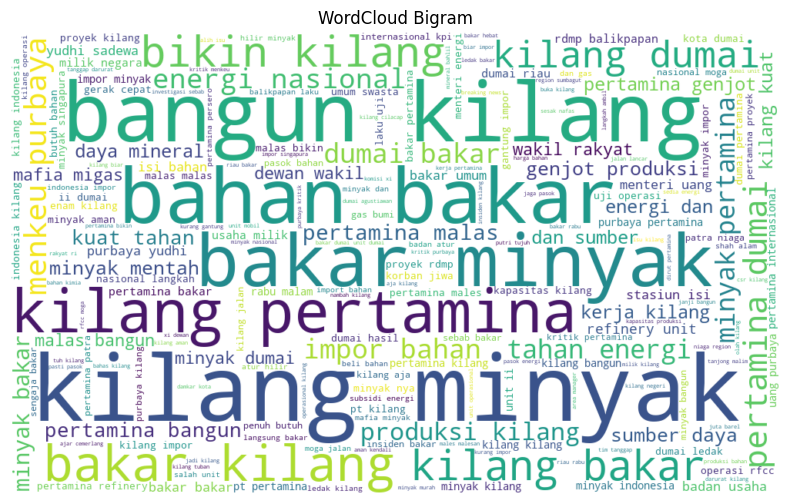

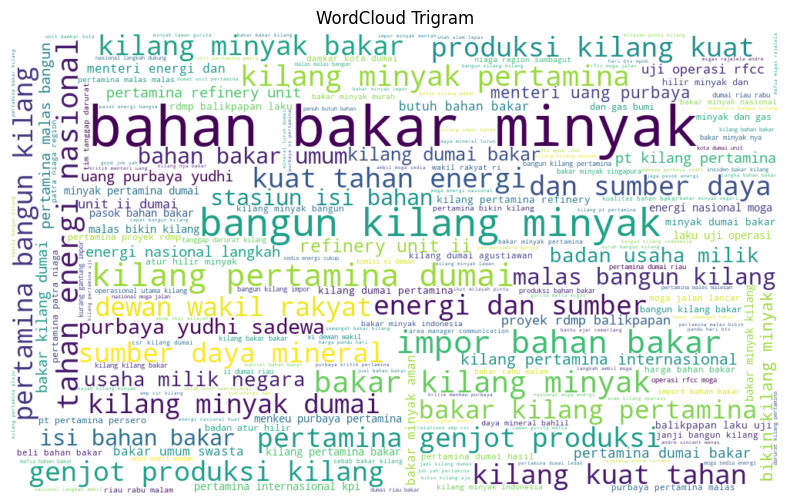

In [18]:
def generate_ngram_wordcloud(corpus, ngram_range=(2,2), title="WordCloud Bigram"):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    freq_dict = dict(words_freq)
    
    plt.figure(figsize=(10,6))
    wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(freq_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

generate_ngram_wordcloud(corpus, ngram_range=(1,1), title="WordCloud Unigram")
generate_ngram_wordcloud(corpus, ngram_range=(2,2), title="WordCloud Bigram")
generate_ngram_wordcloud(corpus, ngram_range=(3,3), title="WordCloud Trigram")

<h1>Pelabelan Self-Training
</h1>

In [19]:
labeled_df = df[df["label"].notna()]
unlabeled_df = df[df["label"].isna()]
print("Total labeled:", len(labeled_df))
print("Total unlabeled:", len(unlabeled_df))

Total labeled: 250
Total unlabeled: 1655


In [20]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_labeled = vectorizer.fit_transform(labeled_df["preprocessing"].astype(str))
y_labeled = labeled_df["label"].astype(str)

X_unlabeled = vectorizer.transform(unlabeled_df["preprocessing"].astype(str))


In [23]:
base_clf = LogisticRegression(max_iter=500)

self_training_model = SelfTrainingClassifier(
    base_clf,
    threshold=0.95,
    verbose=True
)

In [24]:
X_all = np.vstack([X_labeled.toarray(), X_unlabeled.toarray()])

y_all = pd.concat([
    y_labeled,
    pd.Series([-1] * len(unlabeled_df))
], ignore_index=True)

self_training_model.fit(X_all, y_all)

SelfTrainingClassifier(estimator=LogisticRegression(max_iter=500),
                       threshold=0.95, verbose=True)

In [25]:
pseudo_labels = self_training_model.predict(X_unlabeled)
pseudo_probs = self_training_model.predict_proba(X_unlabeled).max(axis=1)

unlabeled_df["pseudo_label"] = pseudo_labels
unlabeled_df["confidence"] = pseudo_probs

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16492\3474361691.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled_df["pseudo_label"] = pseudo_labels
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16492\3474361691.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled_df["confidence"] = pseudo_probs


In [26]:
final_df = pd.concat([
    labeled_df.rename(columns={"label": "final_label"}),
    unlabeled_df.rename(columns={"pseudo_label": "final_label"})
], ignore_index=True)

final_df.to_csv("label_self_training.csv", index=False)

print("\n=== LABEL DISTRIBUTION AFTER SELF TRAINING ===")
print(final_df["final_label"].value_counts())


=== LABEL DISTRIBUTION AFTER SELF TRAINING ===
final_label
negative    984
positive    851
neutral      70
Name: count, dtype: int64


<h1>Visualisasi</h1>

In [27]:
df_label = pd.read_csv("label_self_training.csv")

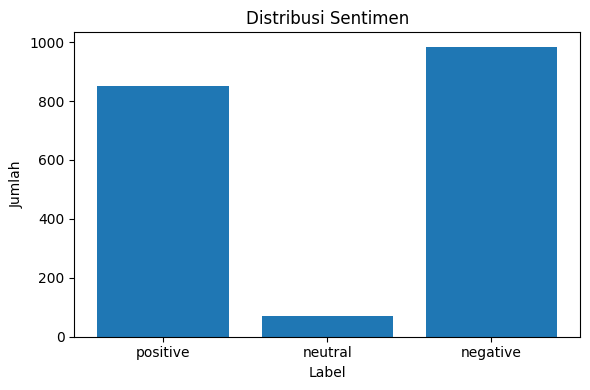

In [28]:
label_counts = df_label["final_label"].value_counts()
order = ["positive", "neutral", "negative"]

counts_ordered = [label_counts.get(lbl, 0) for lbl in order]

plt.figure(figsize=(6,4))
plt.bar(order, counts_ordered)
plt.title("Distribusi Sentimen")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()